# Import Packages

In [1]:
!pip install yfinance   # Install Yahoo Finance library

import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Stock Data Download

In [2]:
def download(stock):  
    """
    Download the stock historical data.

    Parameters
    ----------
    stock: str
      Stock symbol.

    Returns
    -------
    DataFrame
      Downloaded stock data.
    """

    df = yf.download(
         [stock],
         start="2017-01-01",
         end="2022-01-01",
         group_by="ticker", 
         progress=False
         )
    df = df.round(4)
    
    return df


# Download five stocks
df_AAPL = download('AAPL')
df_AMZN = download('AMZN')
df_GOOGL = download('GOOGL')
df_META = download('META')
df_MSFT = download('MSFT')

# Set the input feature
aapl_input = df_AAPL['Adj Close'] 
amzn_input = df_AMZN['Adj Close'] 
googl_input = df_GOOGL['Adj Close'] 
meta_input = df_META['Adj Close'] 
msft_input = df_MSFT['Adj Close'] 

# Data Normalization


In [3]:
# Set the scaler to a range between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))

# Fit the scaler to data, and then transform it
aapl_scaled = scaler.fit_transform(aapl_input.values.reshape(-1,1))
amzn_scaled  = scaler.fit_transform(amzn_input.values.reshape(-1,1))
googl_scaled = scaler.fit_transform(googl_input.values.reshape(-1,1))
meta_scaled = scaler.fit_transform(meta_input.values.reshape(-1,1))
msft_scaled = scaler.fit_transform(msft_input.values.reshape(-1,1))

# Data Processing & Data Split

In [4]:
# Process the data to fit the prediction's format: Use previous n days' data to predict the next day data 

def data_processing(data , sliding_window_number):
    """
    Process the data 

    Parameters
    ----------
    data: Numpy array
      Training or testing data.
    sliding_window_number: int
      Number of days.

    Returns
    -------
    Numpy array
      Independent (X) and dependent (y) variables data of training or testing data.
    """
    
    # dataX stores the previous n days' data; dataY stores the day (n+1) data
    dataX, dataY = [], []
    for i in range(sliding_window_number,len(data)):  
        # Append the data from (i-sliding window number)th to (i-1)th
        dataX.append(data[i-sliding_window_number:i,0])   
        # Append the i(th) data
        dataY.append(data[i,0])               

    return np.array(dataX), np.array(dataY)


#----------------------------------------------------------------------------------
# Apple 
# Split data into training & testing dataset  
train_aapl = aapl_scaled[0:880,:]
test_aapl = aapl_scaled[880:,:]

# Process the input data
X_train_aapl, y_train_aapl = data_processing(train_aapl, 10)
X_test_aapl, y_test_aapl = data_processing(test_aapl, 10)

# Reshape to fit the LSTM required input shape (number of samples, time steps, features per sample)
X_train_aapl = X_train_aapl.reshape(X_train_aapl.shape[0],X_train_aapl.shape[1],1)
X_test_aapl = X_test_aapl.reshape(X_test_aapl.shape[0],X_test_aapl.shape[1],1)

#----------------------------------------------------------------------------------
# Amazon
train_amzn = amzn_scaled[0:880,:]
test_amzn = amzn_scaled[880:,:]

X_train_amzn, y_train_amzn = data_processing(train_amzn, 10)
X_test_amzn, y_test_amzn = data_processing(test_amzn, 10)

X_train_amzn = X_train_amzn.reshape(X_train_amzn.shape[0],X_train_amzn.shape[1],1)
X_test_amzn = X_test_amzn.reshape(X_test_amzn.shape[0],X_test_amzn.shape[1],1)

#----------------------------------------------------------------------------------
# Google
train_googl = googl_scaled[0:880,:]
test_googl = googl_scaled[880:,:]

X_train_googl, y_train_googl = data_processing(train_googl, 10)
X_test_googl, y_test_googl = data_processing(test_googl, 10)

X_train_googl = X_train_googl.reshape(X_train_googl.shape[0],X_train_googl.shape[1],1)
X_test_googl = X_test_googl.reshape(X_test_googl.shape[0],X_test_googl.shape[1],1)

#----------------------------------------------------------------------------------
# Meta
train_meta = meta_scaled[0:880,:]
test_meta = meta_scaled[880:,:]

X_train_meta, y_train_meta = data_processing(train_meta, 10)
X_test_meta, y_test_meta = data_processing(test_meta, 10)

X_train_meta = X_train_meta.reshape(X_train_meta.shape[0],X_train_meta.shape[1],1)
X_test_meta = X_test_meta.reshape(X_test_meta.shape[0],X_test_meta.shape[1],1)

#----------------------------------------------------------------------------------
# Microsoft
train_msft = msft_scaled[0:880,:]
test_msft = msft_scaled[880:,:]

X_train_msft, y_train_msft = data_processing(train_msft, 10)
X_test_msft, y_test_msft = data_processing(test_msft, 10)

X_train_msft = X_train_msft.reshape(X_train_msft.shape[0],X_train_msft.shape[1],1)
X_test_msft = X_test_msft.reshape(X_test_msft.shape[0],X_test_msft.shape[1],1)

# Early Stopping

In [5]:
# Callback - Early Stopping used in LSTM model 

earlystopping = EarlyStopping(monitor='val_loss', mode='min', min_delta=0 ,patience=10, verbose=1)

# LSTM Model Training & Prediction




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 10, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
3/3 [=============================

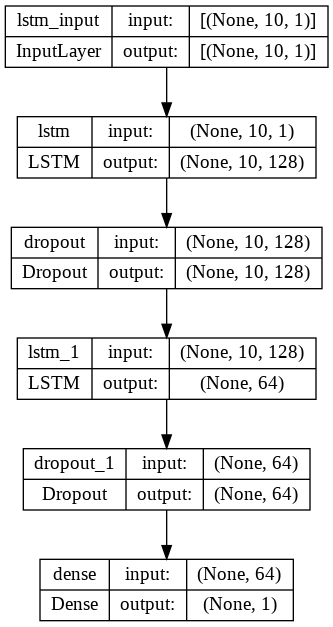

In [6]:
# Apply LSTM model to five stocks

def LSTM_model():
    """
    Build the LSTM model architecture.

    Parameters
    ----------
    None.

    Returns
    -------
    LSTM model architecture.
    """
  
    model = Sequential()    
  
    model.add(LSTM(128, return_sequences=True, input_shape=(10,1)))   
    model.add(Dropout(0.2))  
    model.add(LSTM(64))    
    model.add(Dropout(0.2))
    model.add(Dense(1))  

    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    
    return model


# Model Training
#----------------------------------------------------------------------------------
# Apple
# Instantiate the model 
model_aapl = LSTM_model()   
print(model_aapl.summary())
# Fit the model
history_aapl = model_aapl.fit(X_train_aapl, y_train_aapl, batch_size=256, epochs=50, validation_split=0.2, callbacks=[earlystopping])  
# Predict the results
y_pred_aapl = model_aapl.predict(X_test_aapl)

#----------------------------------------------------------------------------------
# Amazon
model_amzn = LSTM_model()
history_amzn = model_amzn.fit(X_train_amzn, y_train_amzn, batch_size=256, epochs=50, validation_split=0.2, callbacks=[earlystopping]) 
y_pred_amzn = model_amzn.predict(X_test_amzn)

#----------------------------------------------------------------------------------
# Google
model_googl = LSTM_model()
history_googl = model_googl.fit(X_train_googl, y_train_googl, batch_size=256, epochs=50, validation_split=0.2, callbacks=[earlystopping]) 
y_pred_googl = model_googl.predict(X_test_googl)

#----------------------------------------------------------------------------------
# Meta
model_meta = LSTM_model()
history_meta = model_meta.fit(X_train_meta, y_train_meta, batch_size=256, epochs=50, validation_split=0.2, callbacks=[earlystopping]) 
y_pred_meta = model_meta.predict(X_test_meta)

#----------------------------------------------------------------------------------
# Microsoft
model_msft = LSTM_model()
history_msft = model_msft.fit(X_train_msft, y_train_msft, batch_size=256, epochs=50, validation_split=0.2, callbacks=[earlystopping]) 
y_pred_msft = model_msft.predict(X_test_msft)


# An image description of the model structure 
plot_model(model_aapl, to_file='model_structure.png', show_shapes=True)

# Loss Function

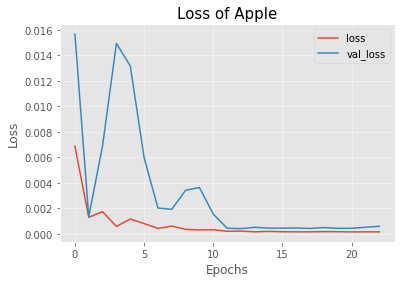

None 



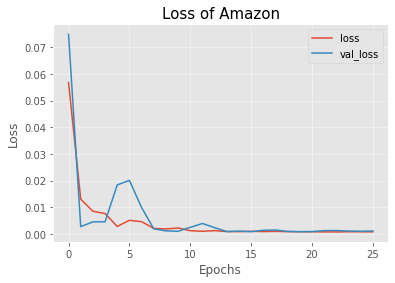

None 



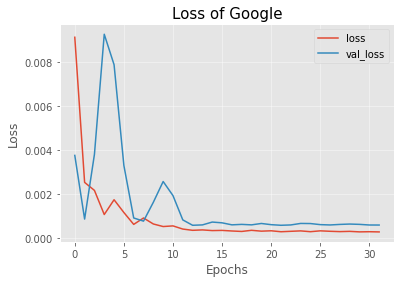

None 



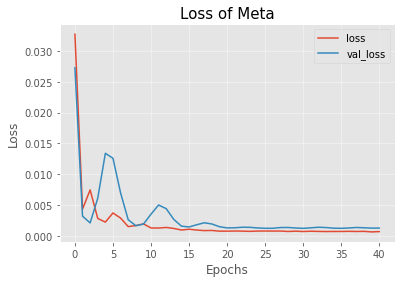

None 



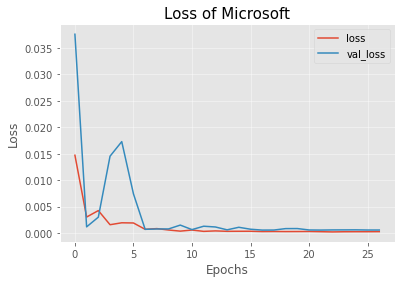

None 



In [7]:
# Plot the loss function

def loss(history, company):
    """
    Plot the loss function

    Parameters
    ----------
    history: Keras callbacks History

    company: str
      Company name.

    Returns
    -------
    None
    """

    plt.style.use('ggplot')
    plt.plot(history.history['loss'], label="loss")
    plt.plot(history.history['val_loss'], label="val_loss")

    plt.legend(fontsize=10)
    plt.title(f'Loss of {company}', fontsize=15)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(alpha=0.5)

    plt.show()
  
        
stock_list = {'Apple': history_aapl, 'Amazon': history_amzn, 'Google': history_googl, 'Meta': history_meta, 'Microsoft': history_msft}

for company, history in stock_list.items():
    print(loss(history, company),'\n')

# RMSE

In [8]:
# Measure the prediction by RMSE metric 

print(f'Apple RMSE: {metrics.mean_squared_error(y_test_aapl, y_pred_aapl, squared=False)}')
print(f'Amazon RMSE: {metrics.mean_squared_error(y_test_amzn, y_pred_amzn, squared=False)}')
print(f'Google RMSE: {metrics.mean_squared_error(y_test_googl, y_pred_googl, squared=False)}')
print(f'Meta RMSE: {metrics.mean_squared_error(y_test_meta, y_pred_meta, squared=False)}')
print(f'Microsoft RMSE: {metrics.mean_squared_error(y_test_msft, y_pred_msft, squared=False)}')

Apple RMSE: 0.0418553721525955
Amazon RMSE: 0.03984138796318407
Google RMSE: 0.04382964582179632
Meta RMSE: 0.05675982336635198
Microsoft RMSE: 0.02476745588960046


# Denormalization

In [9]:
# As the predicted stock prices are in normalized formant, denormalization them to the true price format is required

def denormalize(orignial_data, normalized_data):
    """
    Denormalize the predicted stock prices.

    Parameters
    ----------
    orignial_data: Pandas Series
      Original input data.

    normalized_data: Numpy array
      Array to denormalized.
   
    Returns
    -------
    Numpy array
      Denormalized data.
    """

    # Reshape the dimension to only one column
    orignial_data = orignial_data.values.reshape(-1,1)
    normalized_data = normalized_data.reshape(-1,1)

    # Instantiate a MinMaxScaler object
    scaler = MinMaxScaler()   
    scaler.fit_transform(orignial_data)
    
    # Denormalize to the original data format
    denormalized_data = scaler.inverse_transform(normalized_data)

    return denormalized_data
   

# Apple
denormalized_pred_aapl = denormalize(aapl_input, y_pred_aapl) 
denormalized_y_test_aapl = denormalize(aapl_input, y_test_aapl)

# Amazon 
denormalized_pred_amzn = denormalize(amzn_input, y_pred_amzn) 
denormalized_y_test_amzn = denormalize(amzn_input, y_test_amzn)

# Google
denormalized_pred_googl = denormalize(googl_input, y_pred_googl) 
denormalized_y_test_googl = denormalize(googl_input, y_test_googl)

# Meta
denormalized_pred_meta = denormalize(meta_input, y_pred_meta) 
denormalized_y_test_meta = denormalize(meta_input, y_test_meta)

# Microsoft
denormalized_pred_msft = denormalize(msft_input, y_pred_msft) 
denormalized_y_test_msft = denormalize(msft_input, y_test_msft)

# Real Prices vs. Predicted Prices

In [10]:
# Demonstration of the Real Price vs. Predicted Price

comparision_aapl = pd.DataFrame({'Real Price': denormalized_y_test_aapl.flatten(), 
                                 'Predicted Price': denormalized_pred_aapl.flatten()}, index=df_AAPL[890:].index) 
comparision_amzn = pd.DataFrame({'Real Price': denormalized_y_test_amzn.flatten(), 
                                 'Predicted Price': denormalized_pred_amzn.flatten()}, index=df_AMZN[890:].index)
comparision_googl = pd.DataFrame({'Real Price': denormalized_y_test_googl.flatten(), 
                                  'Predicted Price': denormalized_pred_googl.flatten()}, index=df_GOOGL[890:].index)
comparision_meta = pd.DataFrame({'Real Price': denormalized_y_test_meta.flatten(), 
                                 'Predicted Price': denormalized_pred_meta.flatten()}, index=df_META[890:].index)
comparision_msft = pd.DataFrame({'Real Price': denormalized_y_test_msft.flatten(), 
                                 'Predicted Price': denormalized_pred_msft.flatten()}, index=df_MSFT[890:].index)


print(f'Apple: \n {comparision_aapl.head(10)} \n\n')
print(f'Amazon: \n {comparision_amzn.head(10)} \n\n')
print(f'Google: \n {comparision_googl.head(10)} \n\n')
print(f'Meta: \n {comparision_meta.head(10)} \n\n')
print(f'Microsoft: \n {comparision_msft.head(10)} \n\n')

Apple: 
             Real Price  Predicted Price
Date                                   
2020-07-17     94.8499        91.966507
2020-07-20     96.8488        92.486496
2020-07-21     95.5121        92.883400
2020-07-22     95.7804        93.252304
2020-07-23     91.4208        93.448662
2020-07-24     91.1944        93.374275
2020-07-27     93.3557        93.111549
2020-07-28     91.8221        92.874817
2020-07-29     93.5822        92.462997
2020-07-30     94.7145        92.079887 


Amazon: 
             Real Price  Predicted Price
Date                                   
2020-07-17    148.0985       151.469360
2020-07-20    159.8420       151.582687
2020-07-21    156.9145       151.540588
2020-07-22    154.9955       151.828003
2020-07-23    149.3275       151.892334
2020-07-24    150.4455       151.421051
2020-07-27    152.7605       150.826385
2020-07-28    150.0165       150.586304
2020-07-29    151.6765       150.298889
2020-07-30    152.5940       150.232758 


Google: 
      

# Stock Prices Chart

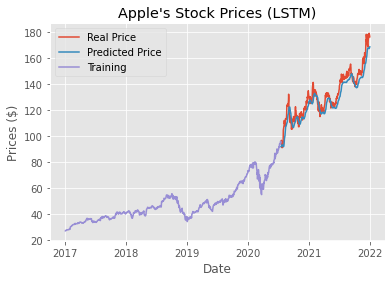

None


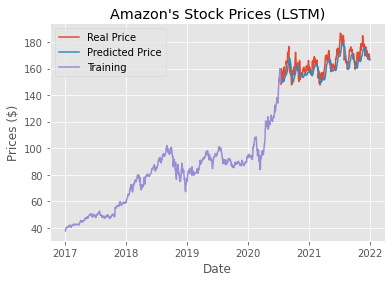

None


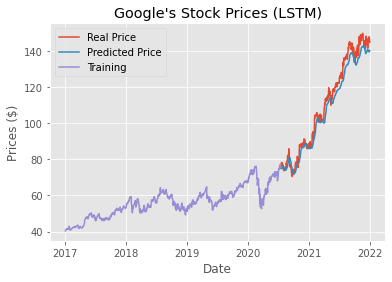

None


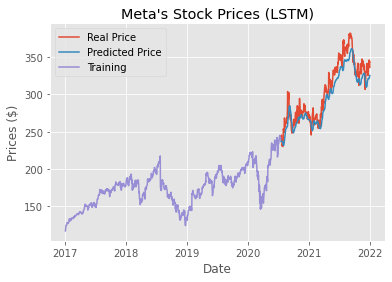

None


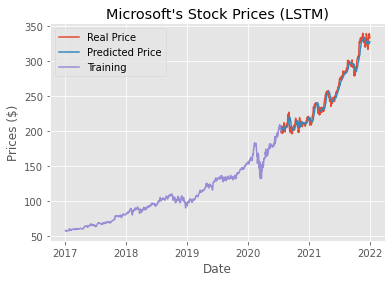

None


In [11]:
# Visualize the predicted results

def result_plot(real, predicted, train, company, model):
    """
    Plot the results in the line chart.

    Parameters
    ----------
    real: Pandas Series
      Real price data.
    predicted:Pandas Series
      Predicted price data.
    train: Pandas Series
      Training data.
    company: str
      Company name.
    model: str
      Model name.

    Returns
    -------
    None
    """

    plt.plot(real, label='Real Price')
    plt.plot(predicted, label='Predicted Price')
    plt.plot(train, label='Training')

    plt.legend(fontsize=10)
    plt.title(f'{company}\'s Stock Prices ({model})')
    plt.xlabel('Date')
    plt.ylabel('Prices ($)')
    plt.show()


print(result_plot(comparision_aapl['Real Price'], comparision_aapl['Predicted Price'], aapl_input[:890], 'Apple', 'LSTM'))   
print(result_plot(comparision_amzn['Real Price'], comparision_amzn['Predicted Price'], amzn_input[:890], 'Amazon', 'LSTM'))   
print(result_plot(comparision_googl['Real Price'], comparision_googl['Predicted Price'], googl_input[:890], 'Google', 'LSTM')) 
print(result_plot(comparision_meta['Real Price'], comparision_meta['Predicted Price'], meta_input[:890], 'Meta', 'LSTM')) 
print(result_plot(comparision_msft['Real Price'], comparision_msft['Predicted Price'], msft_input[:890], 'Microsoft', 'LSTM')) 